# Pre-Processing Methods

Use this notebook to set parameters and make a parameters script for running image pre-processing. This preprocessing corrects problems in the images, specifically systematic differences in exposure across an image, smooth background noise to preserve edges, and fix color abberation. Run this script after pre-sorting images using "Preprocessing Filters". 

In order to use this effectively, each batch of images should have a "brightfield" blank taken with the same microscope and camera settings as the rest of the images in the batch. This brightfield should be of the background that you will be looking at images against (ex. a nitrocellulose filter), but without any objects on it. Give the brightfield image a consistent name across batches. Group batches in folders. 

## Steps:
1. Import brightfield image and smooth with a gaussian filter
2. Import test images
3. Determine correction factor for exposure correction
4. Determine settings for bilateral filter (edge-preserving)
5. Test affine transformation for color abberation

## 1. Brightfield image

The brightfield image should have the same name for all batches, and be located in the same folder as the rest of the images for a batch. For best results, take it concurrently with the same microscope and camera settings. 

Max: 255; Min: 2


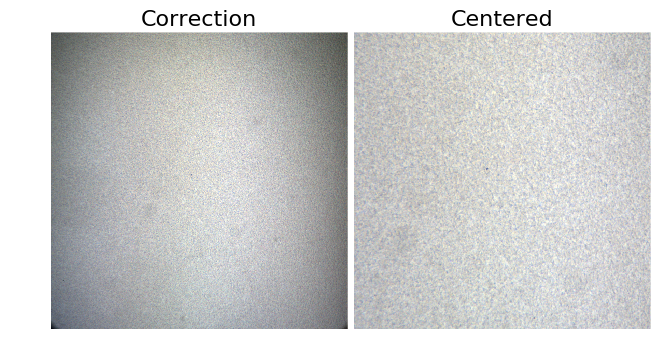

In [1]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/HLD Pictures Feb 2017/02-05-2017"
bright = "BRIGHTFIELD.png"
# dark = "brightfield0003.tif"
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_ubyte, img_as_float, restoration, measure
import pyroots as pr
import numpy as np
from scipy import ndimage
import cv2
from multiprocessing import Pool  
from multiprocessing.dummy import Pool as ThreadPool
import os
import warnings

bright = io.imread(os.path.join(dir_in, bright))

img = bright
print("Max: {}; Min: {}".format(img.max(), img.min()))
pr.multi_image_plot([img, pr._center_image(img)], ['Correction', 'Centered'])

### Make a correction image using gaussian blur
Set `brightfield_sigma` to smooth most background noise, but maintain the differences in exposure you see (including, say, dirt on the camera lens). 

Max: 223; Min: 29


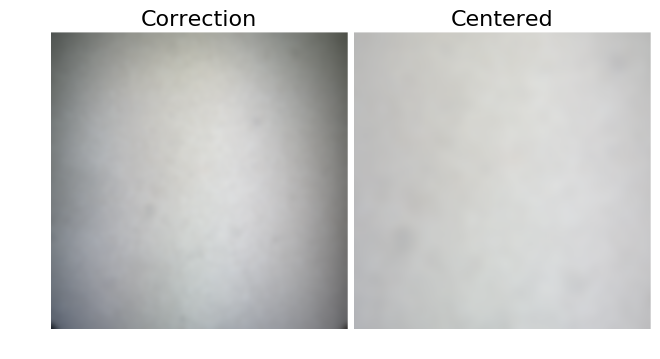

In [2]:
###########################################################
make_brightfield_params = {"brightfield_name"  : "BRIGHTFIELD.png",
                           "brightfield_sigma" : 15}
###########################################################
def _make_correction_image(directory, brightfield_name, brightfield_sigma):
    correction = io.imread(os.path.join(directory, brightfield_name))
    correction = cv2.GaussianBlur(correction, (0, 0), brightfield_sigma)
    return(correction)

correction = _make_correction_image(dir_in, **make_brightfield_params)

img = correction
print("Max: {}; Min: {}".format(img.max(), img.min()))
pr.multi_image_plot([img, pr._center_image(img)], ['Correction', 'Centered'])

## 2. Load Test Images
Select a few representative images. They should have objects that are both faint and strong, and also exhibit color abberation.

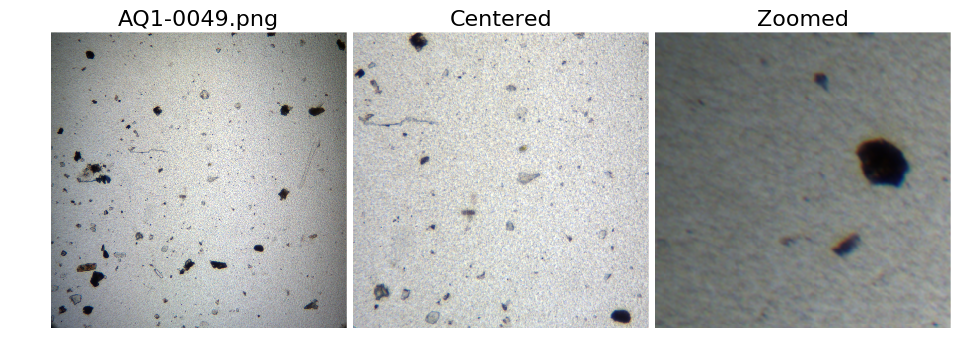

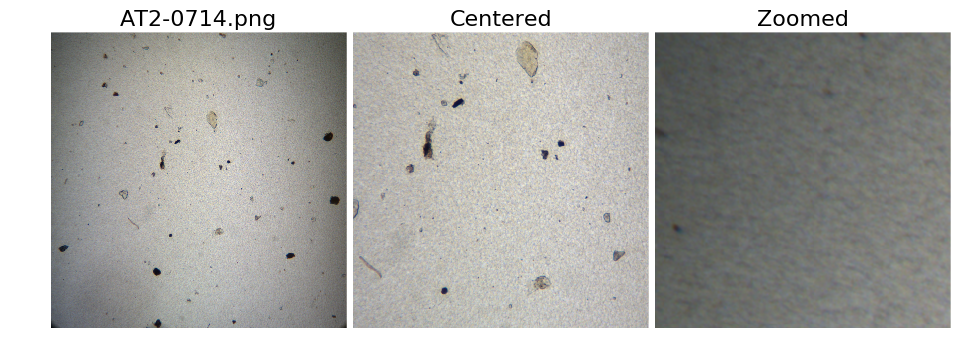

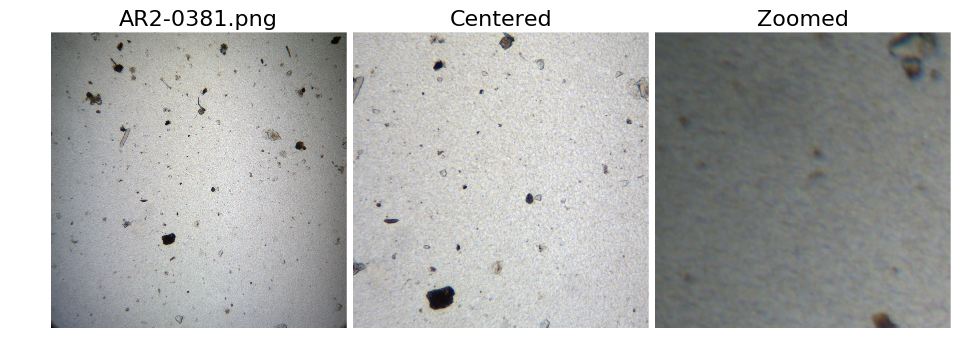

In [4]:
#########################################################################################
file_in = ["AQ1-0049.png", "AT2-0714.png", "AR2-0381.png"]  # can be multiple images
zoom = {'xmin' : 0,
        'xmax' : 300,
        'ymin' : 0,
        'ymax' : 300}
#########################################################################################
test_images = [io.imread(os.path.join(dir_in, i)) for i in file_in]

img_list = test_images
for i in range(len(img_list)):
    img = img_list[i]
    pr.multi_image_plot([img, pr._center_image(img), pr._zoom(img, **zoom)], [file_in[i], "Centered", "Zoomed"])

## 3. Correction factor for brightfield correction
Set a correction factor for exposure brightfield correction. The function, `correct_brightfield`, divides the input image by the correction to return an image of with a range of [0, 1], in theory. However, sometimes the brightfield pixels are of lower value than the input image. This gives an output that appears washed out, and can wash out objects that are faint. 

An ideal correction factor shows a bright background that does not appear washed out. 

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


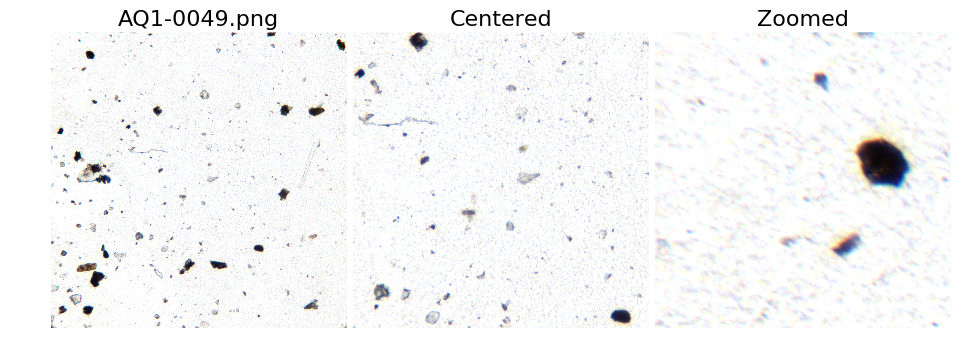

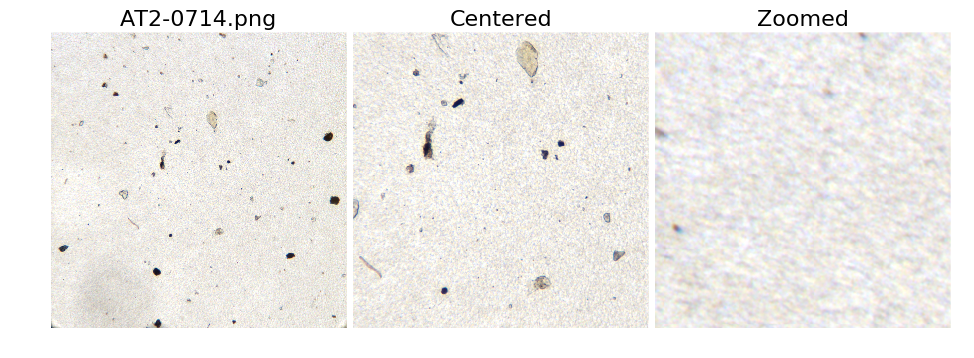

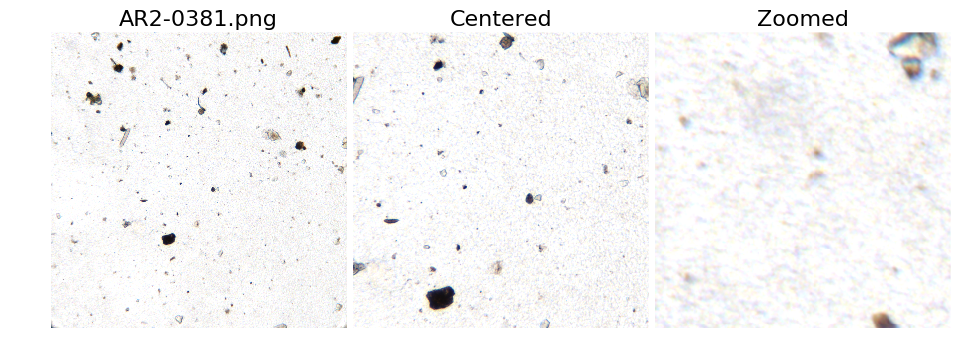

In [5]:
###############################
brightfield_correction_params = {'correction_factor' : 1.0}
###############################

corrected = [pr.correct_brightfield(i, correction, **brightfield_correction_params) for i in test_images]

img_list = corrected
for i in range(len(img_list)):
    img = img_list[i]
    pr.multi_image_plot([img, pr._center_image(img), pr._zoom(img, **zoom)], [file_in[i], "Centered", "Zoomed"])

## 4. Parameters for edge-preserving smoothing
This blurs noise within objects, as defined by pixel value. Pixels that are within `sigmaColor` in value of each other are able to affect each other through a gaussian filter. The gaussian filter behaves with a sigma of `sigmaSpace`. 

The goal is to smooth most background and objects, while avoiding both:
- blending distinct objects that are touching
- blending objects with the background

This is a slow function.

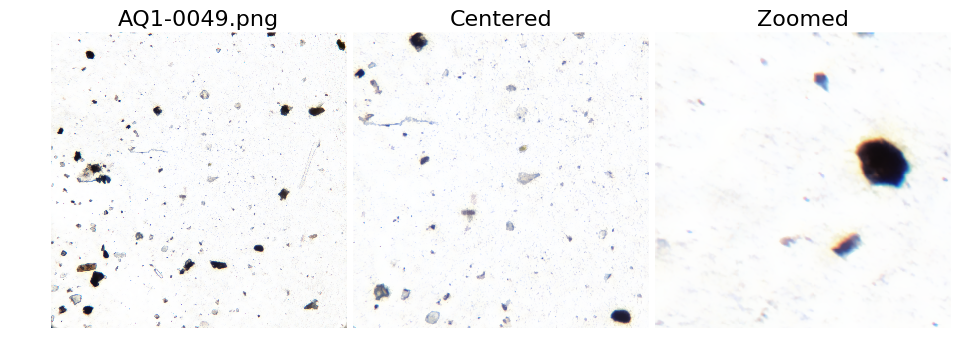

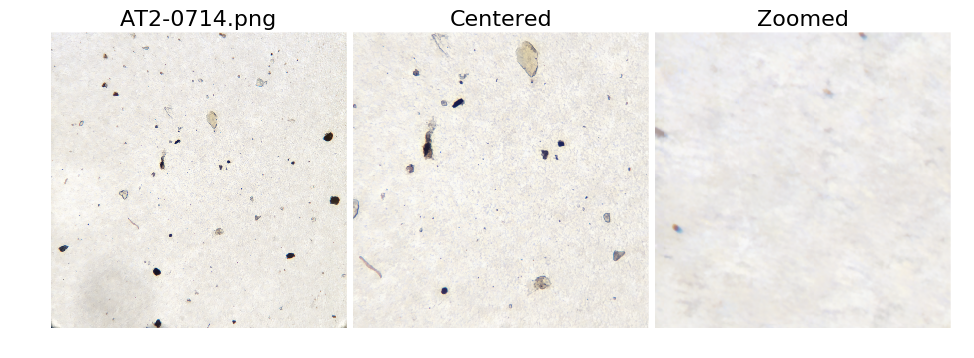

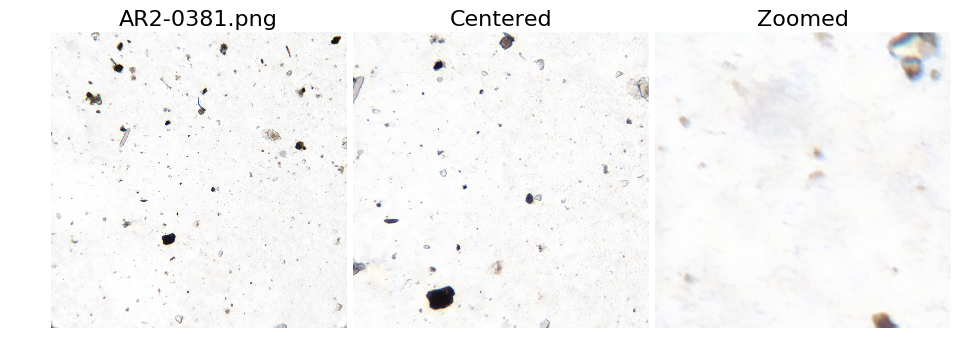

In [12]:
########################################################################################
smoothing_params = {'sigmaColor' : 25,  # Max difference of influence (higher preserves fewer edges)
                    'sigmaSpace' : 10}  # size of gaussian filter (higher smooths more, increases processing quadratically)
# smoothing_params = None

test_image = [0, 1, 2] # what images do you want to run this on? int or list
#########################################################################################
calc = True
calc = False
if calc is True:
    try:
        bilat = [cv2.bilateralFilter(corrected[i], -1, **smoothing_params) for i in test_image]
    except:
        pass
    
img_list = bilat
for i in range(len(img_list)):
    img = img_list[i]
    pr.multi_image_plot([img, pr._center_image(img), pr._zoom(img, **zoom)], [file_in[i], "Centered", "Zoomed"])

## 5. Fix chromatic abberation
Chromatic abberation appears as blue and red edges on high-contrast objects. We want to remove these.

Choose a `template_band` to which to align the others. Also decide if the extra processing time of using `ECC_criterion` is worthwhile. If using it reduces blue or red edges, and your objects are blue or red, then this is probably worthwhile. 

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


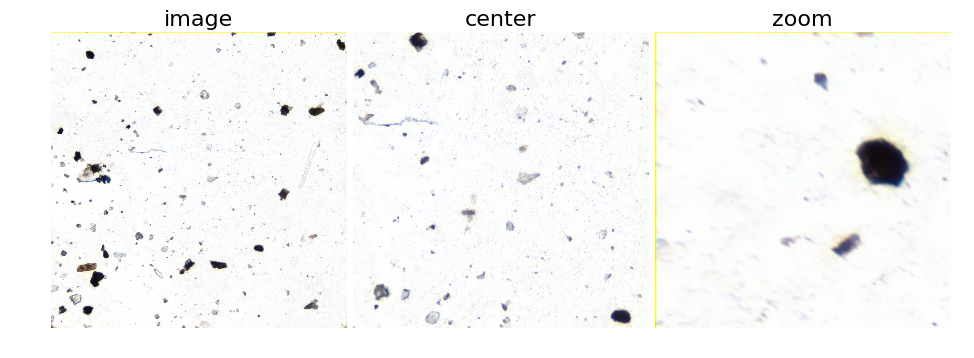

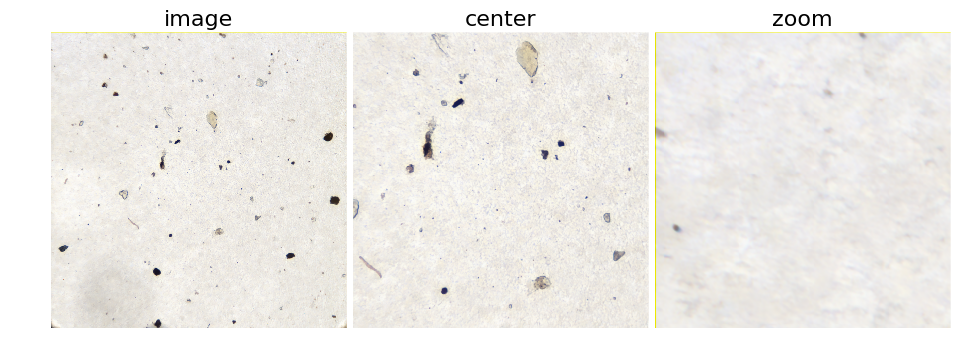

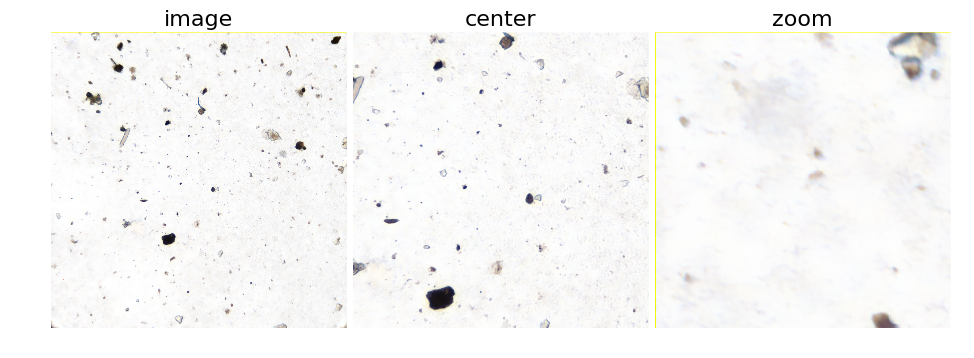

In [7]:
##############################################
registration_params = {'template_band' : 1,  # for green in RGB, the 'middle' band
                       'ECC_criterion'     : True}   # improves results dramatically. Worth the extra processing time. 
# registration_params = None
##############################################
calc = True
calc = False
if calc == True:
    registered = [pr.register_bands(i, **registration_params) for i in bilat]

for i in registered:
    img = i
    pr.multi_image_plot([img, pr._center_image(img), pr._zoom(img, **zoom)], ['image', 'center', 'zoom'])

## 6. Loop Through Images
Try giving bad parameters to raise errors on purpose, ensuring that the warning function works for you

In [ ]:
calc = True
calc = False
if calc == True:
    test_out = [pr.preprocessing_actions(i, 
                                         correction, 
                                         brightfield_params, 
                                         registration_params, 
                                         smoothing_params, 
                                         count_warnings=True) \
                for i in test_images]
    warnings = [i[1] for i in test_out]
    test_out = [i[0] for i in test_out]

print(warnings)
for i in test_out:
    img = i
    pr.multi_image_plot([img, pr._center_image(img), pr._zoom(img, **zoom)], 
                        ['image', 'center', 'zoom'])

## 7. Export Parameters
Choose where to export your parameters for running later on. 

In [13]:
##################
write_params_to = "/home/patrick/Documents/HLD Pictures Feb 2017/preprocessing_actions_02-15-2017.py"

write = False
write = True
##################
dicts = ['make_brightfield_params', 
         'brightfield_correction_params',
         'smoothing_params',
         'registration_params']

if write is True:
    with open(write_params_to, 'w') as file:
        for i in dicts:        
            try:
                print(i + " = " + str(globals()[i]), file=file)
            except:
                print(i + " = " + str(None), file=file)
    
    print("Wrote to: " + write_params_to + "\n")
    for i in dicts:
        try:
            print(i + " = " + str(globals()[i]))
        except:
            print(i + " = " + str(None))

Wrote to: /home/patrick/Documents/HLD Pictures Feb 2017/preprocessing_actions_02-15-2017.py

make_brightfield_params = {'brightfield_sigma': 15, 'brightfield_name': 'BRIGHTFIELD.png'}
brightfield_correction_params = {'correction_factor': 1.0}
smoothing_params = {'sigmaColor': 25, 'sigmaSpace': 10}
registration_params = {'template_band': 1, 'ECC_criterion': True}


In [ ]:
pr.preprocessing_actions_loop(dir_in, 
                              '.png', 
                              os.path.join(dir_in, "TEST"), 
                              '.png', 
                              params=write_params_to, 
                              threads=4)

The parameters you've loaded are:

make_brightfield_params = {'brightfield_sigma': 15, 'brightfield_name': 'BRIGHTFIELD.png'}
brightfield_correction_params = {'correction_factor': 1.0}
smoothing_params = {'sigmaColor': 25, 'sigmaSpace': 10}
registration_params = {'template_band': 1, 'ECC_criterion': True}
Already Analyzed: AQ2-0219.png
Already Analyzed: AQ2-0208.png
Already Analyzed: AT2-0716.png
Already Analyzed: AS2-0553.png
Already Analyzed: AQ1-0032.png
Already Analyzed: AQ1-0075.png
Already Analyzed: AR2-0357.png
Already Analyzed: AT1-0655.png
Already Analyzed: AR2-0402.png


/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


PASSED: AS2-0537.png
PASSED: AT2-0730.png
PASSED: AT1-0616.png
PASSED: AR1-0270.png
PASSED: AQ1-0094.png
PASSED: AS2-0483.png
PASSED: AQ2-0229.png
PASSED: AQ1-0104.png
PASSED: AQ2-0183.png
PASSED: AS2-0484.png
PASSED: AR1-0332.png
PASSED: AR2-0370.png
PASSED: AT1-0590.png
Couldn't load: /home/patrick/Documents/HLD Pictures Feb 2017/02-05-2017/AQ1-0099.png. Continuing...
PASSED: AT2-0758.png
PASSED: AT2-0695.png
PASSED: AQ1-0003.png
PASSED: AS2-0481.png
PASSED: AR2-0395.png
PASSED: AR1-0283.png
PASSED: AR1-0328.png
PASSED: AT2-0666.png
PASSED: AS2-0522.png
PASSED: AT2-0703.png
PASSED: AR2-0431.png
PASSED: AR2-0455.png
PASSED: AT1-0638.png
PASSED: AR1-0342.png
PASSED: AR1-0308.png
PASSED: AQ1-0041.png
PASSED: AQ1-0108.png
PASSED: AQ2-0130.png
PASSED: AS2-0473.png
PASSED: AT2-0753.png
PASSED: AQ2-0211.png
PASSED: AT1-0629.png
PASSED: AR1-0330.png
PASSED: AQ2-0135.png
PASSED: AS2-0523.png
PASSED: AS2-0485.png
PASSED: AQ2-0204.png
PASSED: AQ1-0061.png
PASSED: AR2-0427.png
PASSED: AT2-0694.p

/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/HLD Pictures Feb 2017/02-05-2017/TEST/AS2-0471.png is a low contrast image
  warn('%s is a low contrast image' % fname)


PASSED: AT1-0577.png
PASSED: AS2-0471.png
PASSED: AR1-0315.png
PASSED: AR2-0434.png
PASSED: AR1-0237.png
PASSED: AQ1-0027.png
PASSED: AT2-0740.png
PASSED: AT2-0734.png
PASSED: AS2-0498.png
PASSED: AR2-0358.png
PASSED: AT1-0586.png
PASSED: AR2-0443.png
PASSED: AQ2-0210.png
PASSED: AS2-0509.png
PASSED: AQ1-0100.png
PASSED: AQ2-0167.png
PASSED: AT2-0750.png
PASSED: AS2-0510.png
PASSED: AR1-0325.png
PASSED: AT1-0598.png
PASSED: AQ1-0062.png
PASSED: AT1-0585.png
PASSED: AR1-0282.png
PASSED: AT1-0605.png
PASSED: AQ1-0040.png
PASSED: AQ2-0171.png
PASSED: AQ1-0096.png
PASSED: AQ2-0156.png
PASSED: AR1-0246.png
PASSED: AQ2-0190.png
PASSED: AT2-0689.png
PASSED: AR1-0293.png
PASSED: AQ1-0103.png
PASSED: AQ2-0146.png
PASSED: AT1-0595.png
PASSED: AQ1-0065.png
PASSED: AT1-0642.png
PASSED: AR1-0265.png
PASSED: AR2-0405.png
PASSED: AS2-0482.png
PASSED: AR2-0389.png
PASSED: AQ1-0098.png
PASSED: AQ1-0067.png
PASSED: AT2-0702.png
PASSED: AT1-0610.png
PASSED: AQ1-0053.png
PASSED: AQ1-0092.png
PASSED: AS2-0

In [ ]:
def preprocessing_actions_loop(dir_in, 
                               extension_in, 
                               dir_out,
                               extension_out=".png",
                               params=None,
                               threads=1):
    """
    Combines preprocessing filters (blur, color, contrast) into a loop. Convenient to run as a vehicle to transfer images
    from a portable drive to a permanent area. 
    
    Parameters
    ----------
    base_directory : str
        Directory to the images or subdirectories containing the images. 
    extension_in : str
        Extension of images to analyze
    out_dir : str
        Name of directory to write output images. `None` to skip.
    extension_out : str
        Extension to save images.
    params : str
        Path + filename for parameters file for `pyroots.preprocessing_filters`. If `None` (default), only
        loads and (possibly) resaves images. If not `None`, will only save images that pass test. See notes for format.
    threads : int
        For multiprocessing
    
    Returns
    -------
    Image files.
        
    Notes
    -----
    The `params` file should have the following objects: `make_correction_params`, 
    `brightfield_correction_params`, 'registration_params', and `low_contrast_params`.
    All are dictionaries with items named as arguments in respective functions. If not present, 
    will default to `None`. Will raise a `UserWarning` if the format and names are not correct (but not if `None`). 
    
    """
    
    
    try:
        exec(open(params).read(), globals())
    except:
        if params is not None:
            raise ValueError("Couldn't load params file. Try checking it for words like 'array' or\n'uint8' that need to be loaded with numpy and load these\n functions using `extra_imports`.... Or edit source.")
    
    # make sure all dictionaries have something assigned to them, including None
    dicts = ['make_brightfield_params', 
             'brightfield_correction_params',
             'smoothing_params',
             'registration_params']
    for i in dicts:
        try:
            print(i + " = " + str(globals()[i]))
        except:
            print(i + " = " + str(None))
            globals()[i] = None
    
    # initiate loop
    for path, folder, file in os.walk(dir_in):  
        if dir_out not in path:   # Don't run in the output directory.
            # ID the current folder 
            subpath = path[len(dir_in)+1:]

            # Make directories for saving images
            if dir_out is not None:
                if not os.path.exists(os.path.join(dir_out, subpath)):
                    os.mkdir(os.path.join(dir_out, subpath))
                    os.mkdir(os.path.join(dir_out, "FAILED PROCESSES", subpath))
                    
            # make a brightfield correction image for the directory
            def _make_brightfield_image(directory, brightfield_name, brightfield_sigma):
                correction = io.imread(os.path.join(directory, brightfield_name))
                correction = cv2.GaussianBlur(correction, (0, 0), brightfield_sigma)
                return(correction)
            try:
                correction = _make_brightfield_image(path, **make_brightfield_params)
            except:
                warnings.warn("\nCould not make correction image. Does\n{}\nexist?\nContinuing to next folder...\n".format(\
                     os.path.join(subpath, make_correction_params['brightfield_name'])))
                continue  # can't do this folder, so move on to the next
            
            
            
            def _core_fn(filename):
                if filename.endswith(extension_in):
                    path_in = os.path.join(path, filename)  # what's the image called and where is it?
                    
                    # possible locations to write the output file
                    filename_out = os.path.splitext(filename)[0] + extension_out
                    path_out_PASS = os.path.join(dir_out, subpath, filename_out)
                    path_out_FAIL = os.path.join(dir_out, "FAILED PROCESSES", subpath, filename_out)
                    
                    # skip if already analyzed
                    if os.path.exists(path_out_PASS) or os.path.exists(path_out_FAIL):
                        print("Already Analyzed: {}".format(os.path.join(subpath, filename)))
                    
                    else:  # analyze
                        try:
                            img = io.imread(path_in)  # load image
                        except:
                            print("Couldn't load: {}. Continuing...".format(path_in))
                            return
                        
                        img_out, warnings = pr.preprocessing_actions(img, 
                                                                  correction, 
                                                                  brightfield_correction_params, 
                                                                  registration_params, 
                                                                  smoothing_params, 
                                                                  count_warnings=True)
                        
                        # where to write the output file?
                        if warnings == 0:
                            if dir_out is not None:
                                io.imsave(path_out_PASS, img_out)
                            print("PASSED: {}".format(os.path.join(subpath, filename)))

                        else:
                            if dir_out is not None:
                                io.imsave(path_out_FAIL, img_out)
                            print("Something Failed: {}".format(os.path.join(subpath, filename)))
                
            thread_pool = ThreadPool(threads)
            # Work on _core_fn
            thread_pool.map(_core_fn, file)
            # finish
            thread_pool.close()
            thread_pool.join()
        
    return("Done")

### Save the correction for future reference

In [ ]:
save = False
# save = True
if save is True:
    io.imsave("/home/patrick/Documents/HLD Pictures Feb 2017/02-06-2017/ Exposure Correction.tif", img_as_ubyte(correction))
    correction = io.imread("/home/patrick/Documents/HLD Pictures Feb 2017/02-06-2017/ Exposure Correction.tif")
    plt.imshow(correction)

In [ ]:
################################################################
settings_path = '/home/patrick/Documents/HLD Pictures Feb 2017/Settings/'
settings_name = 'preprocessing_settings.py'  
write = False                                 # update items as changed? 
write = True
################################################################

base_directory = dir_in
extension_in = ".tif"
extension_out = '.png'
brightfield_image = "/home/patrick/Documents/HLD Pictures Feb 2017/02-06-2017/ Exposure Correction.tif"
out_dir = dir_in + "preprocessed"
save_images = True
threads = 4

dicts = [#base_directory, 
#          extension_in, 
#          extension_out,
#          brightfield_image, 
         "correction_factor",
         "registration_band",
         "bilateral_args",
#          out_dir,
#          save_images,
#          threads
]

if write is True:
    with open(settings_path + settings_name, 'w') as file:
        for i in dicts:
            print(i + " = " + str(locals()[i]), file=file)

for i in dicts:
    print(i + " = " + str(locals()[i]))

In [ ]:
calc = False
calc = True
if calc is True:  # S-L-O-W
    x = preprocessing_loop(dir_in, 
                           ".png", extension_out=".png",
                           brightfield_image=correction,
                           correction_factor=correction_factor,
                           registration_band=None,
                           bilateral_args=bilateral_args, 
                           out_dir=dir_in + "preprocessed/", #"/home/patrick/Documents/HLD Pictures Feb 2017/02-09-2017",  # CHANGE THIS EACH DAY
                           save_images=True, threads=4)

In [ ]:
out_dir=dir_in + "preprocessed/"
print(out_dir)